In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "ILC"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
Cillo2020_L029_HNSCC7_T0_AAACGGGAGGCTAGAC,Cillo2020,Cillo2020_L029,Cillo2020_HNSCC7_T0,3_GEX_V2,HNSCC,male,71-80,ILC,NK_CD56dimCD16
Cillo2020_L029_HNSCC7_T0_AAACGGGGTGAAGGCT,Cillo2020,Cillo2020_L029,Cillo2020_HNSCC7_T0,3_GEX_V2,HNSCC,male,71-80,ILC,NK_CD56dimCD16
Cillo2020_L029_HNSCC7_T0_AAACGGGGTGTGGTTT,Cillo2020,Cillo2020_L029,Cillo2020_HNSCC7_T0,3_GEX_V2,HNSCC,male,71-80,ILC,NK_CD56dimCD16
Cillo2020_L029_HNSCC7_T0_AAATGCCCACGGTGTC,Cillo2020,Cillo2020_L029,Cillo2020_HNSCC7_T0,3_GEX_V2,HNSCC,male,71-80,ILC,NK_lowRibocontent
Cillo2020_L029_HNSCC7_T0_AACCGCGGTGACGCCT,Cillo2020,Cillo2020_L029,Cillo2020_HNSCC7_T0,3_GEX_V2,HNSCC,male,71-80,ILC,NK_CD56dimCD16
...,...,...,...,...,...,...,...,...,...
Ren2021_L059_PS046_T0_TTTATGCCAGACGCCT,Ren2021,Ren2021_L059,Ren2021_PS046_T0,5_GEX_V2,COVID,male,>80,ILC,NK_CD56dimCD16
Ren2021_L059_PS046_T0_TTTCCTCAGGAATCGC,Ren2021,Ren2021_L059,Ren2021_PS046_T0,5_GEX_V2,COVID,male,>80,ILC,NK_lowRibocontent
Ren2021_L059_PS046_T0_TTTCCTCAGGCCCGTT,Ren2021,Ren2021_L059,Ren2021_PS046_T0,5_GEX_V2,COVID,male,>80,ILC,NK_lowRibocontent


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
15,4,3,0.597453,0.697985,0.417013
13,4,1,0.679675,0.626625,0.425901
14,4,2,0.719875,0.631953,0.454927
1,0,2,0.790011,0.631953,0.499250
0,0,1,0.819159,0.626625,0.513306
2,0,3,0.772925,0.697985,0.539490
7,2,1,0.878831,0.626625,0.550697
4,1,2,0.878831,0.631953,0.555380
10,3,1,0.925284,0.626625,0.579806
12,3,4,0.597453,1.000000,0.597453


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

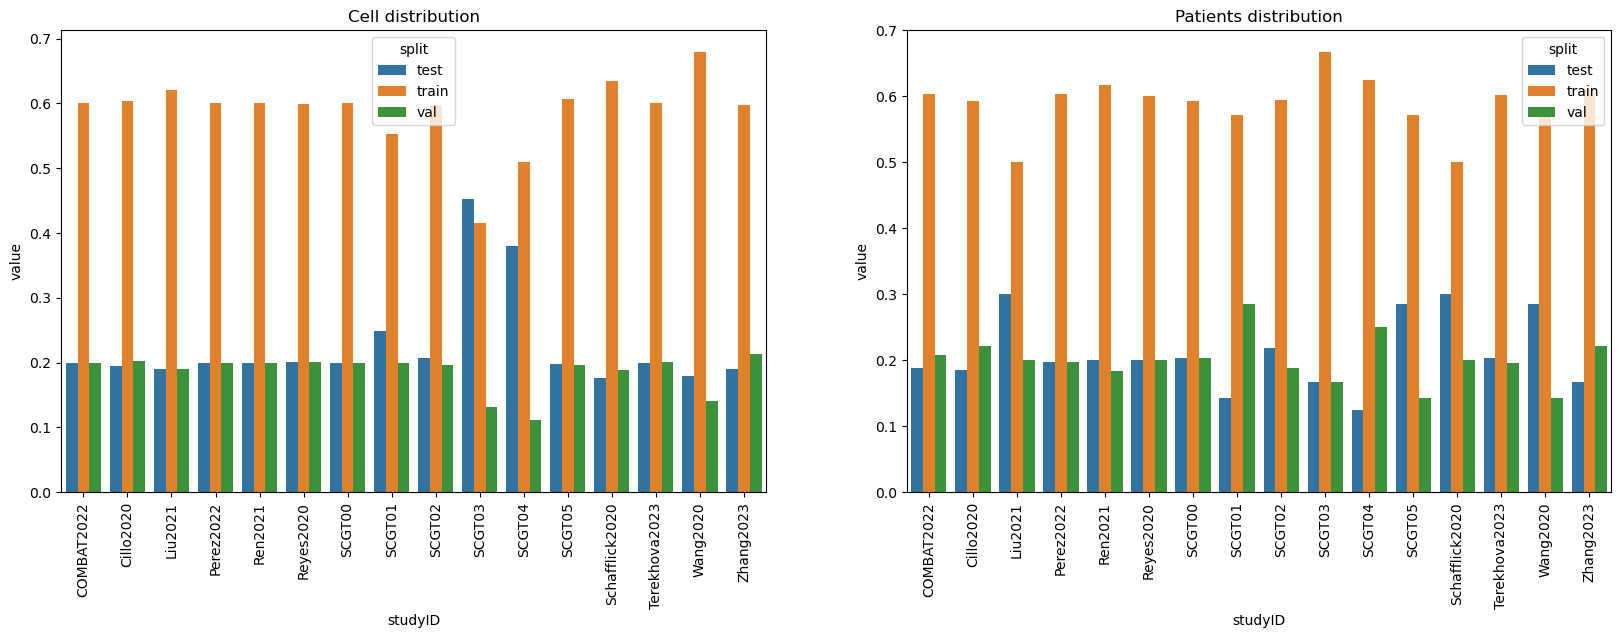

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((224971, 935), (77820, 935), (74094, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((224971,), (77820,), (74094,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-17 23:29:05,845] A new study created in memory with name: no-name-cd209ce9-d83f-41d5-a69c-640194072dda


/tmp/ipykernel_1205207/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250317_232910-2huun3um
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_ILC


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/2huun3um


[I 2025-03-17 23:30:32,564] Trial 0 finished with value: -0.985201 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.985201.


[I 2025-03-17 23:31:04,327] Trial 1 finished with value: -0.998445 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:31:15,711] Trial 2 finished with value: -0.977909 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:34:15,325] Trial 3 finished with value: -0.997508 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:35:42,803] Trial 4 finished with value: -0.998124 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:35:56,442] Trial 5 pruned. Trial was pruned at iteration 34.


[I 2025-03-17 23:36:08,544] Trial 6 finished with value: -0.996082 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:36:13,398] Trial 7 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:36:17,945] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:36:22,047] Trial 9 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:36:51,597] Trial 10 finished with value: -0.997341 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9725833997090791, 'colsample_bynode': 0.11616568805333755, 'learning_rate': 0.17780618353487967}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:37:16,150] Trial 11 finished with value: -0.997437 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.340143041503771, 'colsample_bynode': 0.40131565860091256, 'learning_rate': 0.057899203666416425}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:37:21,010] Trial 12 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:37:25,926] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:37:31,118] Trial 14 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 23:37:35,971] Trial 15 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:37:40,754] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:37:45,552] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:37:51,083] Trial 18 pruned. Trial was pruned at iteration 2.


[I 2025-03-17 23:37:56,103] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:01,150] Trial 20 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:06,002] Trial 21 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:11,051] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:15,796] Trial 23 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:20,758] Trial 24 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:30,649] Trial 25 pruned. Trial was pruned at iteration 17.


[I 2025-03-17 23:38:35,552] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:40,487] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:45,664] Trial 28 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 23:38:50,498] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:38:55,357] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:39:29,277] Trial 31 finished with value: -0.997361 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.3641618150909678, 'colsample_bynode': 0.3850915826464003, 'learning_rate': 0.05011800000205376}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:39:34,205] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:39:39,440] Trial 33 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 23:40:00,271] Trial 34 finished with value: -0.99791 and parameters: {'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.20477182764154095, 'colsample_bynode': 0.3007913033690299, 'learning_rate': 0.2395889902069954}. Best is trial 1 with value: -0.998445.


[I 2025-03-17 23:40:05,076] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:09,899] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:14,671] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:19,531] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:24,558] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:29,593] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:35,001] Trial 41 pruned. Trial was pruned at iteration 1.


[I 2025-03-17 23:40:39,887] Trial 42 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:46,917] Trial 43 pruned. Trial was pruned at iteration 7.


[I 2025-03-17 23:40:51,801] Trial 44 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:40:56,699] Trial 45 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:41:02,457] Trial 46 pruned. Trial was pruned at iteration 3.


[I 2025-03-17 23:41:07,408] Trial 47 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 23:41:13,627] Trial 48 pruned. Trial was pruned at iteration 4.


[I 2025-03-17 23:41:18,821] Trial 49 pruned. Trial was pruned at iteration 0.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_ILC_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:2.17460	validation_0-custom_f1_score:-0.96106


[1]	validation_0-mlogloss:1.85005	validation_0-custom_f1_score:-0.97666


[2]	validation_0-mlogloss:1.62268	validation_0-custom_f1_score:-0.97638


[3]	validation_0-mlogloss:1.44123	validation_0-custom_f1_score:-0.98505


[4]	validation_0-mlogloss:1.29503	validation_0-custom_f1_score:-0.98306


[5]	validation_0-mlogloss:1.17063	validation_0-custom_f1_score:-0.98447


[6]	validation_0-mlogloss:1.06192	validation_0-custom_f1_score:-0.98920


[7]	validation_0-mlogloss:0.96742	validation_0-custom_f1_score:-0.99099


[8]	validation_0-mlogloss:0.88347	validation_0-custom_f1_score:-0.99287


[9]	validation_0-mlogloss:0.80964	validation_0-custom_f1_score:-0.99327


[10]	validation_0-mlogloss:0.74363	validation_0-custom_f1_score:-0.99390


[11]	validation_0-mlogloss:0.68376	validation_0-custom_f1_score:-0.99431


[12]	validation_0-mlogloss:0.62961	validation_0-custom_f1_score:-0.99462


[13]	validation_0-mlogloss:0.58008	validation_0-custom_f1_score:-0.99503


[14]	validation_0-mlogloss:0.53577	validation_0-custom_f1_score:-0.99529


[15]	validation_0-mlogloss:0.49536	validation_0-custom_f1_score:-0.99530


[16]	validation_0-mlogloss:0.45805	validation_0-custom_f1_score:-0.99578


[17]	validation_0-mlogloss:0.42382	validation_0-custom_f1_score:-0.99584


[18]	validation_0-mlogloss:0.39223	validation_0-custom_f1_score:-0.99611


[19]	validation_0-mlogloss:0.36309	validation_0-custom_f1_score:-0.99622


[20]	validation_0-mlogloss:0.33695	validation_0-custom_f1_score:-0.99632


[21]	validation_0-mlogloss:0.31276	validation_0-custom_f1_score:-0.99639


[22]	validation_0-mlogloss:0.29002	validation_0-custom_f1_score:-0.99660


[23]	validation_0-mlogloss:0.26951	validation_0-custom_f1_score:-0.99662


[24]	validation_0-mlogloss:0.25037	validation_0-custom_f1_score:-0.99670


[25]	validation_0-mlogloss:0.23291	validation_0-custom_f1_score:-0.99667


[26]	validation_0-mlogloss:0.21671	validation_0-custom_f1_score:-0.99668


[27]	validation_0-mlogloss:0.20153	validation_0-custom_f1_score:-0.99677


[28]	validation_0-mlogloss:0.18772	validation_0-custom_f1_score:-0.99674


[29]	validation_0-mlogloss:0.17484	validation_0-custom_f1_score:-0.99680


[30]	validation_0-mlogloss:0.16274	validation_0-custom_f1_score:-0.99681


[31]	validation_0-mlogloss:0.15155	validation_0-custom_f1_score:-0.99684


[32]	validation_0-mlogloss:0.14128	validation_0-custom_f1_score:-0.99693


[33]	validation_0-mlogloss:0.13166	validation_0-custom_f1_score:-0.99698


[34]	validation_0-mlogloss:0.12283	validation_0-custom_f1_score:-0.99704


[35]	validation_0-mlogloss:0.11466	validation_0-custom_f1_score:-0.99707


[36]	validation_0-mlogloss:0.10734	validation_0-custom_f1_score:-0.99710


[37]	validation_0-mlogloss:0.10062	validation_0-custom_f1_score:-0.99704


[38]	validation_0-mlogloss:0.09426	validation_0-custom_f1_score:-0.99707


[39]	validation_0-mlogloss:0.08807	validation_0-custom_f1_score:-0.99711


[40]	validation_0-mlogloss:0.08252	validation_0-custom_f1_score:-0.99712


[41]	validation_0-mlogloss:0.07741	validation_0-custom_f1_score:-0.99710


[42]	validation_0-mlogloss:0.07276	validation_0-custom_f1_score:-0.99715


[43]	validation_0-mlogloss:0.06843	validation_0-custom_f1_score:-0.99709


[44]	validation_0-mlogloss:0.06436	validation_0-custom_f1_score:-0.99715


[45]	validation_0-mlogloss:0.06065	validation_0-custom_f1_score:-0.99712


[46]	validation_0-mlogloss:0.05697	validation_0-custom_f1_score:-0.99717


[47]	validation_0-mlogloss:0.05374	validation_0-custom_f1_score:-0.99715


[48]	validation_0-mlogloss:0.05082	validation_0-custom_f1_score:-0.99708


[49]	validation_0-mlogloss:0.04798	validation_0-custom_f1_score:-0.99711


[50]	validation_0-mlogloss:0.04539	validation_0-custom_f1_score:-0.99710


[51]	validation_0-mlogloss:0.04293	validation_0-custom_f1_score:-0.99713


[52]	validation_0-mlogloss:0.04077	validation_0-custom_f1_score:-0.99713


[53]	validation_0-mlogloss:0.03865	validation_0-custom_f1_score:-0.99715


[54]	validation_0-mlogloss:0.03680	validation_0-custom_f1_score:-0.99708


[55]	validation_0-mlogloss:0.03506	validation_0-custom_f1_score:-0.99706


[56]	validation_0-mlogloss:0.03347	validation_0-custom_f1_score:-0.99692


[57]	validation_0-mlogloss:0.03212	validation_0-custom_f1_score:-0.99683


[58]	validation_0-mlogloss:0.03049	validation_0-custom_f1_score:-0.99692


[59]	validation_0-mlogloss:0.02887	validation_0-custom_f1_score:-0.99698


[60]	validation_0-mlogloss:0.02747	validation_0-custom_f1_score:-0.99701


[61]	validation_0-mlogloss:0.02634	validation_0-custom_f1_score:-0.99695


[62]	validation_0-mlogloss:0.02521	validation_0-custom_f1_score:-0.99701


[63]	validation_0-mlogloss:0.02426	validation_0-custom_f1_score:-0.99698


[64]	validation_0-mlogloss:0.02337	validation_0-custom_f1_score:-0.99690


[65]	validation_0-mlogloss:0.02254	validation_0-custom_f1_score:-0.99697


[66]	validation_0-mlogloss:0.02181	validation_0-custom_f1_score:-0.99689


[67]	validation_0-mlogloss:0.02105	validation_0-custom_f1_score:-0.99687


[68]	validation_0-mlogloss:0.02041	validation_0-custom_f1_score:-0.99685


[69]	validation_0-mlogloss:0.01986	validation_0-custom_f1_score:-0.99679


[70]	validation_0-mlogloss:0.01899	validation_0-custom_f1_score:-0.99692


[71]	validation_0-mlogloss:0.01836	validation_0-custom_f1_score:-0.99688


[72]	validation_0-mlogloss:0.01779	validation_0-custom_f1_score:-0.99693


[73]	validation_0-mlogloss:0.01725	validation_0-custom_f1_score:-0.99697


[74]	validation_0-mlogloss:0.01668	validation_0-custom_f1_score:-0.99697


[75]	validation_0-mlogloss:0.01630	validation_0-custom_f1_score:-0.99694


[76]	validation_0-mlogloss:0.01598	validation_0-custom_f1_score:-0.99689


[77]	validation_0-mlogloss:0.01572	validation_0-custom_f1_score:-0.99687


[78]	validation_0-mlogloss:0.01532	validation_0-custom_f1_score:-0.99687


[79]	validation_0-mlogloss:0.01504	validation_0-custom_f1_score:-0.99688


[80]	validation_0-mlogloss:0.01470	validation_0-custom_f1_score:-0.99685


[81]	validation_0-mlogloss:0.01434	validation_0-custom_f1_score:-0.99680


[82]	validation_0-mlogloss:0.01408	validation_0-custom_f1_score:-0.99685


[83]	validation_0-mlogloss:0.01381	validation_0-custom_f1_score:-0.99688


[84]	validation_0-mlogloss:0.01351	validation_0-custom_f1_score:-0.99688


[85]	validation_0-mlogloss:0.01325	validation_0-custom_f1_score:-0.99689


[86]	validation_0-mlogloss:0.01296	validation_0-custom_f1_score:-0.99692


[87]	validation_0-mlogloss:0.01274	validation_0-custom_f1_score:-0.99690


[88]	validation_0-mlogloss:0.01253	validation_0-custom_f1_score:-0.99694


[89]	validation_0-mlogloss:0.01241	validation_0-custom_f1_score:-0.99694


[90]	validation_0-mlogloss:0.01220	validation_0-custom_f1_score:-0.99688


[91]	validation_0-mlogloss:0.01194	validation_0-custom_f1_score:-0.99689


[92]	validation_0-mlogloss:0.01180	validation_0-custom_f1_score:-0.99694


[93]	validation_0-mlogloss:0.01154	validation_0-custom_f1_score:-0.99702


[94]	validation_0-mlogloss:0.01143	validation_0-custom_f1_score:-0.99701


[95]	validation_0-mlogloss:0.01123	validation_0-custom_f1_score:-0.99707


[96]	validation_0-mlogloss:0.01118	validation_0-custom_f1_score:-0.99697


[97]	validation_0-mlogloss:0.01097	validation_0-custom_f1_score:-0.99707


[98]	validation_0-mlogloss:0.01090	validation_0-custom_f1_score:-0.99701


[99]	validation_0-mlogloss:0.01080	validation_0-custom_f1_score:-0.99706


[100]	validation_0-mlogloss:0.01074	validation_0-custom_f1_score:-0.99699


[101]	validation_0-mlogloss:0.01060	validation_0-custom_f1_score:-0.99706


[102]	validation_0-mlogloss:0.01055	validation_0-custom_f1_score:-0.99701


[103]	validation_0-mlogloss:0.01041	validation_0-custom_f1_score:-0.99704


[104]	validation_0-mlogloss:0.01045	validation_0-custom_f1_score:-0.99704


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.6410035105688879,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x74adc007f880>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08148293210105287, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=105, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_ILC_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[23:42:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


